In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.cluster import AgglomerativeClustering
import gower
from scipy.cluster.hierarchy import dendrogram
from sklearn.ensemble import RandomForestClassifier

__DATENVORBEREITUNG__

In [3]:
# load data
cad_data = pd.read_excel(r"C:\Users\IM-KI\Documents\PrEvelOp_Docs\PrEvelOp_20231130_CAD_Export_01_Bu.xlsx")

# select first 49 rows, data from CAPicard
CAPicard_data = cad_data[:49]

C:\Users\IM-KI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# set column key as index
CAPicard_data = CAPicard_data.set_index('Key')

<Axes: title={'center': "Boxplot for 'brand' vs 'price'"}, xlabel='None'>

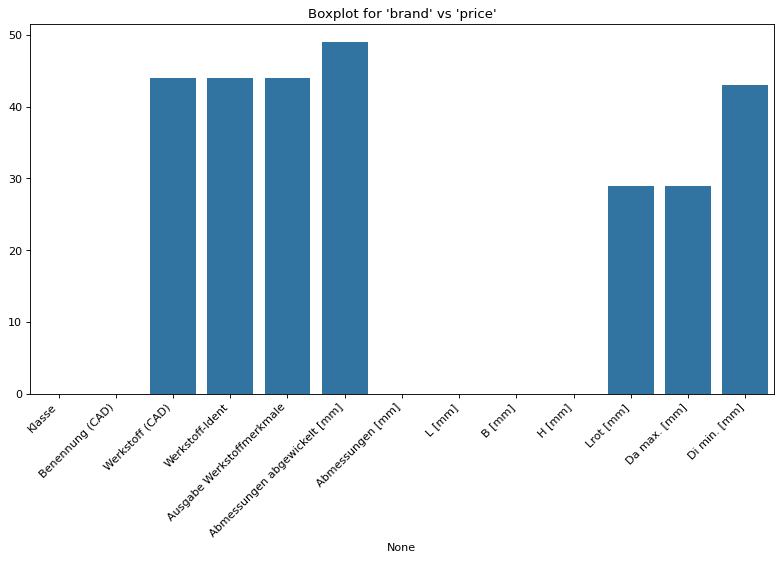

In [5]:
# plot NaN values per column
plt.figure(figsize=(12, 6), dpi=80)
plt.title("Boxplot for 'brand' vs 'price'")
plt.xticks(rotation=45, ha='right')
nan_data = CAPicard_data.isna().sum()[CAPicard_data.isna().sum()>=0]
sns.barplot(x=nan_data.index, y=nan_data.values)

In [6]:
# drop columns with mostly NaN values and irrelevant columns: 'Abmessungen [mm]' column
CAPicard_data.drop('Abmessungen [mm]', axis=1, inplace=True)
CAPicard_data.drop('Werkstoff-Ident', axis=1, inplace=True)
CAPicard_data.drop('Ausgabe Werkstoffmerkmale', axis=1, inplace=True)
CAPicard_data.drop('Abmessungen abgewickelt [mm]', axis=1, inplace=True)

In [7]:
# create columns 'Klasse1', ... , 'Klasse6' and map classes in 'Klasse' to respecting columns
Klassen = [[] for i in range(6)]
for index, value in CAPicard_data['Klasse'].items():
    classes = value.split('|')
    for i in range(6):
        if len(classes) > i:
            Klassen[i].append(classes[i])
        else:
            Klassen[i].append(None)

for i in range(6):
    CAPicard_data.insert(i+1, 'Klasse'+str(i+1), Klassen[i])

In [8]:
# drop column 'Klasse'
CAPicard_data.drop('Klasse', axis=1, inplace=True)

In [9]:
# Map 'ValueNotDefined' in 'Werkstoff (CAD)' to NaN
CAPicard_data['Werkstoff (CAD)'].replace('ValueNotDefined', np.nan, inplace=True)

In [10]:
# make values in columns representing numeric values numeric
for col in ['L [mm]', 'B [mm]', 'H [mm]', 'Lrot [mm]', 'Da max. [mm]', 'Di min. [mm]']:
    CAPicard_data[col] = CAPicard_data[col].str.extract('(\d+)').astype(float)

In [11]:
# visualize process data in CAPicard data, folder: Blech
process_data = pd.read_csv(r"C:\Users\IM-KI\Documents\PrEvelOp_Daten_CAPicard\Teile\Blech\ST-3830.csv", encoding="ISO-8859-1", sep=';')
process_data

,AkvP,geän,IDAktv,Aktivitätenart,Aktivität,Bezeichnung,Druckgruppe,Ressourcenart,BRes/AltResGr,ZME,Rüstzeit,ZEtr,Stückzeit,ZEte,Rückmeldekennzeichen
0,10,ja,1672069,Produktion,1-Lasern auf Rohmaß,"...auf 1300 x 900 x 5,8 mm",NaN,Arbeitsplatz,335713,Stk,"15,00",Min,"4,00",Min,Rückmeldung erforderlich
1,20,nein,1672070,Produktion,1-Richten von Hand,...Achtung !!!,NaN,Arbeitsplatz,161000,Stk,"10,00",Min,"63,00",Min,Rückmeldung erforderlich
2,30,ja,1672071,Produktion,1-Anhalter,NaN,NaN,Arbeitsplatz,162000,Stk,"10,00",Min,"63,00",Min,Rückmeldung erforderlich
3,40,nein,1672072,Produktion,2-Vorschleifen auf,"...5,30 - 0,05 mm",NaN,Arbeitsplatz,225134,Stk,"20,00",Min,"24,00",Min,Rückmeldung erforderlich
4,50,nein,1672073,Produktion,1-Richten von Hand,...Achtung !!!,NaN,Arbeitsplatz,161000,Stk,"10,00",Min,"60,00",Min,Rückmeldung erforderlich
5,60,nein,1672074,Produktion,1-Anhalter,NaN,NaN,Arbeitsplatz,162000,Stk,"10,00",Min,"60,00",Min,Rückmeldung erforderlich
6,70,nein,1672075,Produktion,1-Lasern auf Fertigm,...nach Zeichnung,NaN,Arbeitsplatz,335713,Stk,"15,00",Min,"4,00",Min,Rückmeldung erforderlich
7,80,nein,1672076,Produktion,1-Bohren + Fräsen,...nach Zeichnung,NaN,Arbeitsplatz,141258,Stk,"20,00",Min,"35,00",Min,Rückmeldung erforderlich
8,90,nein,1672077,Produktion,1-Fertigschleifen,...nach Zeichnung,NaN,Arbeitsplatz,121000_1,Stk,"15,00",Min,"120,00",Min,Rückmeldung erforderlich
9,100,nein,1672078,Produktion,1-Verputzen,NaN,NaN,Arbeitsplatz,171000,Stk,"5,00",Min,"4,00",Min,Rückmeldung erforderlich


Für jede Zeile in CAPicard_data existiert eine csv-Datei, die die Prozessdaten des Produktes enthält. Die Prozessdaten betehen aus mehreren Zeilen, die die jeweiligen Prozesschritte darstellen (Aktivität). Ziel ist es nun, die Prozessdaten in jeweils eine Zeile pro Produkt zu komprimieren. Einige Spalten wie 'Aktivitätenart', 'Druckgruppe', 'Ressourcenart', 'ZME', 'ZEtr', 'ZEte' oder 'Rückmeldekennzeichen' können  vernachlässigt werden, da sie meist nur einen oder keinen Wert enhalten (Unbrauchbar für Clusterig).

Relevante Spalten sind 'Aktivität', 'BRes/AltResGr' (?), 'Rüstzeit', 'Stückzeit', evtl noch 'Bezeichnung'

Weiterhin können wir Informationen wie z.B. Anzahl an Aktivitäten aus den Prozessdaten entnehmen.

In [12]:
import os

# save process data of instances in list

nr_aktivitaeten = []
aktivitaeten = []
ruestzeiten = []
stueckzeiten = []

for filename in CAPicard_data['Benennung (CAD)'].values:
    url = "C:\\Users\\IM-KI\\Documents\\PrEvelOp_Daten_CAPicard\\Prozessdaten\\" + str(filename) + ".csv"
    if os.path.isfile(url):
        process_data = pd.read_csv(url, encoding="ISO-8859-1", sep=';')
        nr_aktivitaeten.append(len(process_data))
        aktivitaeten.append(process_data['Aktivität'].tolist())
        ruestzeiten.append(process_data['Rüstzeit'].tolist())
        stueckzeiten.append(process_data['Stückzeit'].tolist())
    else:
        nr_aktivitaeten.append(np.NaN)
        aktivitaeten.append(np.NaN)
        ruestzeiten.append(np.NaN)
        stueckzeiten.append(np.NaN) 

In [13]:
# save process data of instances in CAPicard_data
CAPicard_data['Anzahl Aktivitäten'] = nr_aktivitaeten
CAPicard_data['Aktivitäten'] = aktivitaeten
CAPicard_data['Rüstzeiten'] = ruestzeiten
CAPicard_data['Stückzeiten'] = stueckzeiten

In [14]:
# drop columns without process data
CAPicard_data.dropna(subset=['Aktivitäten'], inplace=True)

In [15]:
# create list with all possible activities
aktivitaeten_cleared = [process for process in aktivitaeten if type(process)!=float]
alle_aktivitaeten = list(set([aktivitaet for process in aktivitaeten_cleared for aktivitaet in process]))

In [16]:
count_aktivitaeten = [aktivitaet for process in aktivitaeten_cleared for aktivitaet in process]
# number of activities
a = sum(list(Counter(count_aktivitaeten).values()))
# number of the n most frequent activities
x_values = range(len(alle_aktivitaeten))
y_values = []
for n in x_values:
    b = sum(sorted(list(Counter(count_aktivitaeten).values()), reverse=True)[:n])
    # relative frequencie of the n most frequent rules
    y_values.append(b/a)

Text(0.5, 1.0, 'relative frequencie of the n most frequent activities')

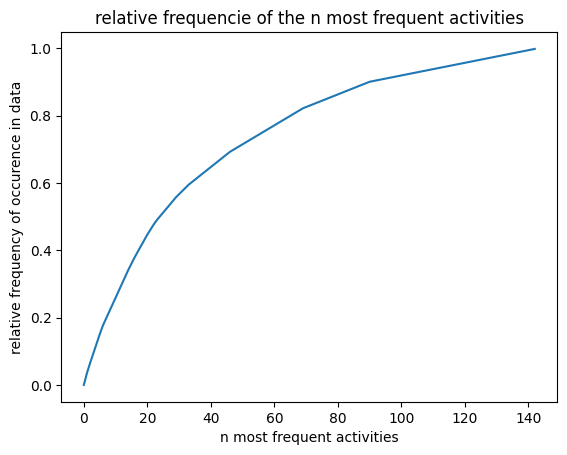

In [17]:
# plot relative frequencie of the n most frequent activities
plt.plot(x_values,y_values)
plt.xlabel('n most frequent activities')
plt.ylabel('relative frequency of occurence in data')
plt.title('relative frequencie of the n most frequent activities')

In [18]:
# select the 25 most frequent activities
activities_frequent = [value[0] for value in Counter(count_aktivitaeten).most_common(25)]

In [19]:
# add a column for each of the 25 most frequent activities 
# add 1 if the activitiy appears in the process of the respective row, 0 otherwise
for act in activities_frequent:
    column_values = [1 if act in process else 0 for process in CAPicard_data['Aktivitäten']]
    CAPicard_data['Aktivität ' + str(act)] = column_values

In [20]:
# transform column 'Rüstzeiten' and 'Stückzeiten' by average value
average_ruestzeiten = []
average_stueckzeiten = []
for i in range(len(CAPicard_data)):
    ruestzeiten_sum = sum([float(ruestzeit.replace(',',''))/100 if type(ruestzeit) == str else float(ruestzeit) for ruestzeit in CAPicard_data.iloc[i]['Rüstzeiten']])
    stueckzeiten_sum = sum([float(stueckzeit.replace(',',''))/100 if type(stueckzeit) == str else float(stueckzeit) for stueckzeit in CAPicard_data.iloc[i]['Stückzeiten']])
    average_ruestzeiten.append(ruestzeiten_sum//CAPicard_data.iloc[i]['Anzahl Aktivitäten'])
    average_stueckzeiten.append(stueckzeiten_sum//CAPicard_data.iloc[i]['Anzahl Aktivitäten'])


In [21]:
# add columns for average values of 'Rüstzeiten' and 'Stückzeiten'
CAPicard_data['Rüstzeiten gemittelt'] = average_ruestzeiten
CAPicard_data['Stückzeiten gemittelt'] = average_stueckzeiten

In [22]:
# drop columns that are not suited for clustering
CAPicard_data.drop(['Klasse4','Klasse5','Klasse6','Benennung (CAD)','Werkstoff (CAD)','Lrot [mm]','Da max. [mm]','Di min. [mm]','Aktivitäten','Rüstzeiten','Stückzeiten'], axis=1, inplace=True)

In [23]:
# select the numerical and categorical columns for preprocessing
num_colums = ['L [mm]', 'B [mm]', 'H [mm]', 'Anzahl Aktivitäten', 'Rüstzeiten gemittelt', 'Stückzeiten gemittelt']
bin_columns = ['Aktivität 6-Sägen', 'Aktivität 6-Konservieren',
       'Aktivität 6-Endkontrolle Kuns', 'Aktivität 2-Eingangskontrolle',
       'Aktivität 1-Versand', 'Aktivität 1-Endkontrolle',
       'Aktivität 6-Drehen Lang', 'Aktivität 2-Endkontrolle',
       'Aktivität 2-Versand', 'Aktivität 1-Verputzen',
       'Aktivität 6-Vordrehen CNC', 'Aktivität 6-Drehen Bohrung',
       'Aktivität 6-Räumen', 'Aktivität 6-Fertigschleifen L',
       'Aktivität 1-Richten von Hand', 'Aktivität 2-Richten von Hand',
       'Aktivität 2-Fräsen / Bohren GT', 'Aktivität 2-Bereitstellung UL',
       'Aktivität 6-Schleifen Kling.', 'Aktivität Härten nach AA',
       'Aktivität 6-Vordrehen', 'Aktivität 2-Richten roh',
       'Aktivität 2-Vorschleifen hart', 'Aktivität 6-Zwischenkontrolle',
       'Aktivität 2-Verputzen',]
cat_columns = ['Klasse1', 'Klasse2', 'Klasse3']

In [24]:
# split the dataframe in with respect to the selected columns
df_num = CAPicard_data[num_colums]
df_bin = CAPicard_data[bin_columns]
df_cat = CAPicard_data[cat_columns]


In [25]:
# scale the numerical columns with MaxAbsScaler
scaler = MaxAbsScaler().fit(df_num)
df_num_scaled = pd.DataFrame(data=scaler.transform(df_num), index=df_num.index, columns=df_num.columns)


In [26]:
# encode the categorical columns
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_cat)
df_cat_encoded = pd.DataFrame(data=enc.transform(df_cat).toarray(), index=df_cat.index, columns=enc.get_feature_names_out())


In [27]:
# concatenate the subdataframes columnwise
CAPicard_processed = pd.concat([df_num_scaled, df_cat_encoded, df_bin], axis=1)
CAPicard_processed.head(5)

,L [mm],B [mm],H [mm],Anzahl Aktivitäten,Rüstzeiten gemittelt,Stückzeiten gemittelt,Klasse1_EXCENTR_001,Klasse1_FLAT_002,Klasse1_FLAT_005,Klasse1_FLAT_007,...,Aktivität 2-Richten von Hand,Aktivität 2-Fräsen / Bohren GT,Aktivität 2-Bereitstellung UL,Aktivität 6-Schleifen Kling.,Aktivität Härten nach AA,Aktivität 6-Vordrehen,Aktivität 2-Richten roh,Aktivität 2-Vorschleifen hart,Aktivität 6-Zwischenkontrolle,Aktivität 2-Verputzen
Key,,,,,,,,,,,,,,,,,,,,,
7090-__XXXX-0-90A-00,1.000000,0.043373,0.257143,0.409091,0.256098,0.793548,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
J140-__XXXX-0-70B-00,0.246671,0.069277,0.410714,0.590909,0.170732,0.651613,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
G093-EG1760-4-24A-01,0.512300,0.027711,0.164286,0.590909,0.243902,0.929032,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
9058-DF2388-0-24A-00,0.668698,0.022892,0.135714,0.545455,0.231707,1.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
02-145-012-003,0.169262,0.094578,0.050000,0.363636,0.182927,0.070968,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,1


__CLUSTERING__

In [28]:
# calculate distance matrix with gower distance
distance_gower = gower.gower_matrix(CAPicard_data)

In [29]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, metric='precomputed', linkage='average', compute_distances=True).fit(distance_gower)

In [30]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(linkage_matrix, **kwargs)

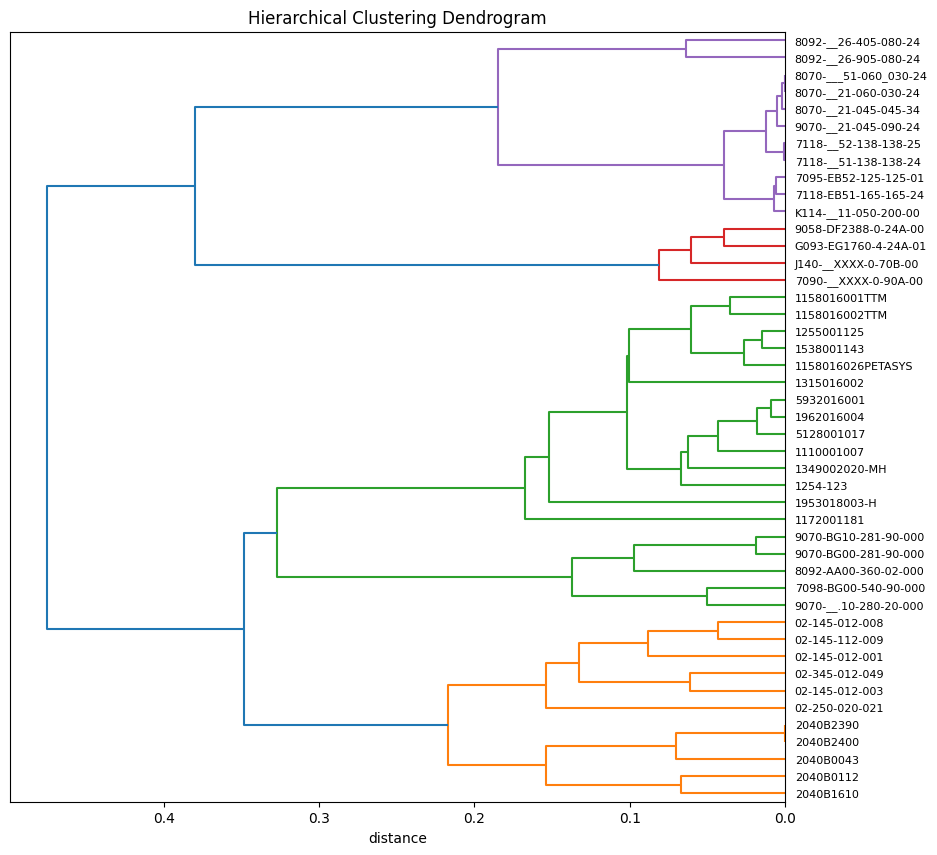

In [31]:
plot_dendrogram(clustering, labels=CAPicard_data.index, orientation='left')

In [32]:
# elbow plot: we want to plot the number of clusters against the sum of within-cluster variance for linkage='average'
cluster_variance_average = []
for k in range(1,46):
    clustering = AgglomerativeClustering(n_clusters=k,  metric='precomputed', linkage='average', compute_distances=True).fit(distance_gower)
    cluster_variance_sum = []
    for i in range(k):
        cluster_indices = []
        for index, cluster in enumerate(list(clustering.labels_)):
            if cluster == i:
                cluster_indices.append(index)
        cluster_len = len(cluster_indices)
        cluster_df = CAPicard_processed.iloc[cluster_indices]
        cluster_df.loc['metoid'] = cluster_df.mean()
        cluster_variance = sum(gower.gower_matrix(cluster_df)[-1])
        cluster_variance_sum.append(cluster_variance)
    cluster_variance_average.append(sum(cluster_variance_sum))

# elbow plot: we want to plot the number of clusters against the sum of within-cluster variance  for linkage='single'
cluster_variance_single = []
for k in range(1,46):
    clustering = AgglomerativeClustering(n_clusters=k,  metric='precomputed', linkage='single', compute_distances=True).fit(distance_gower)
    cluster_variance_sum = []
    for i in range(k):
        cluster_indices = []
        for index, cluster in enumerate(list(clustering.labels_)):
            if cluster == i:
                cluster_indices.append(index)
        cluster_len = len(cluster_indices)
        cluster_df = CAPicard_processed.iloc[cluster_indices]
        cluster_df.loc['metoid'] = cluster_df.mean()
        cluster_variance = sum(gower.gower_matrix(cluster_df)[-1])
        cluster_variance_sum.append(cluster_variance)
    cluster_variance_single.append(sum(cluster_variance_sum))

# elbow plot: we want to plot the number of clusters against the sum of within-cluster variance  for linkage='complete'
cluster_variance_complete = []
for k in range(1,46):
    clustering = AgglomerativeClustering(n_clusters=k,  metric='precomputed', linkage='complete', compute_distances=True).fit(distance_gower)
    cluster_variance_sum = []
    for i in range(k):
        cluster_indices = []
        for index, cluster in enumerate(list(clustering.labels_)):
            if cluster == i:
                cluster_indices.append(index)
        cluster_len = len(cluster_indices)
        cluster_df = CAPicard_processed.iloc[cluster_indices]
        cluster_df.loc['metoid'] = cluster_df.mean()
        cluster_variance = sum(gower.gower_matrix(cluster_df)[-1])
        cluster_variance_sum.append(cluster_variance)
    cluster_variance_complete.append(sum(cluster_variance_sum))


([<matplotlib.axis.XTick at 0x18da3bea350>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

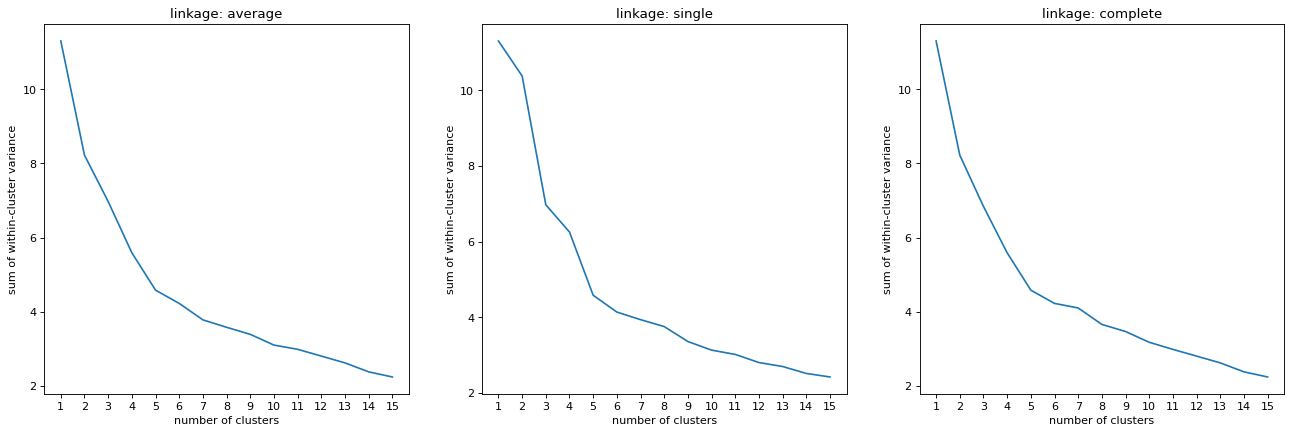

In [33]:
# plot elbow plot for linkage='average'
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1,3,1)
plt.plot(range(1,16), cluster_variance_average[:15])
plt.xlabel('number of clusters')
plt.ylabel('sum of within-cluster variance')
plt.title('linkage: average')
plt.xticks(range(1,16))
# plot elbow plot for linkage='single'
plt.subplot(1,3,2)
plt.plot(range(1,16), cluster_variance_single[:15])
plt.xlabel('number of clusters')
plt.ylabel('sum of within-cluster variance')
plt.title('linkage: single')
plt.xticks(range(1,16))
# plot elbow plot for linkage='complete'
plt.subplot(1,3,3)
plt.plot(range(1,16), cluster_variance_complete[:15])
plt.xlabel('number of clusters')
plt.ylabel('sum of within-cluster variance')
plt.title('linkage: complete')
plt.xticks(range(1,16))


In [34]:
# compare cluster label for differen distance parameters
id_list = CAPicard_data.index.tolist()
clustering_ave = AgglomerativeClustering(n_clusters=5,  metric='precomputed', linkage='average', compute_distances=True).fit(distance_gower)
clustering_sin = AgglomerativeClustering(n_clusters=5,  metric='precomputed', linkage='single', compute_distances=True).fit(distance_gower)
clustering_com = AgglomerativeClustering(n_clusters=5,  metric='precomputed', linkage='complete', compute_distances=True).fit(distance_gower)
labels_distance = pd.DataFrame(index=id_list)
labels_distance['average'] = clustering_ave.labels_
labels_distance['single'] = clustering_sin.labels_
labels_distance['complete'] = clustering_com.labels_
labels_distance


,average,single,complete
7090-__XXXX-0-90A-00,2,3,3
J140-__XXXX-0-70B-00,2,3,3
G093-EG1760-4-24A-01,2,3,3
9058-DF2388-0-24A-00,2,3,3
02-145-012-003,0,4,0
02-145-012-001,0,4,0
02-345-012-049,0,4,0
02-250-020-021,0,4,0
02-145-112-009,0,4,0
02-145-012-008,0,4,0


__EVALUATION__

In [35]:
labels = clustering_ave.labels_

In [36]:
# train a random forest model with cluster labels as target variable and compute the accuracy of the prediction
rf = RandomForestClassifier()
rf.fit(CAPicard_processed, labels)
predict = rf.predict(CAPicard_processed)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
accuracy = accuracy_score(labels, predict)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [37]:
importances = rf.feature_importances_

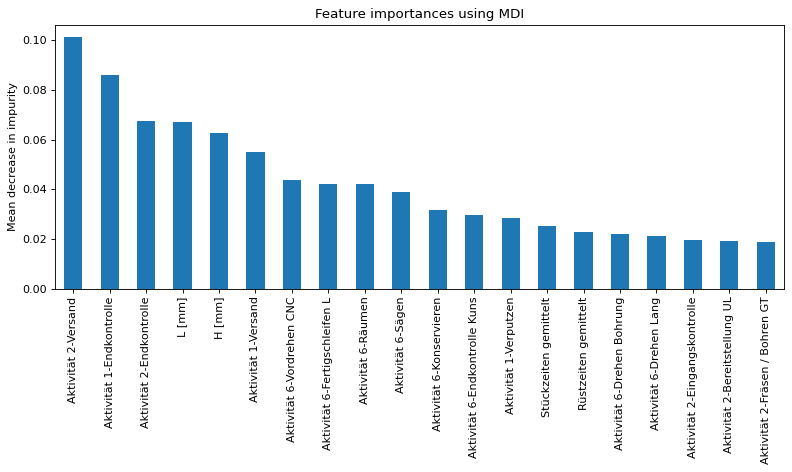

In [40]:
# plot the importances of the features
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=CAPicard_processed.columns)

# create plot that shows the 20 most important features
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
forest_importances.nlargest(20).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()